## Preparation

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.4.0
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.3.3
numpy 1.18.4
pandas 1.1.5
sklearn 0.24.0
tensorflow 2.4.0
tensorflow.keras 2.4.0


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.allow_soft_placement=True
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
session = InteractiveSession(config=config)

In [3]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
# print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

(20640, 8)
(20640,)


In [4]:
from sklearn.model_selection import train_test_split
xtrain_all, xtest, ytrain_all, ytest = train_test_split(housing.data, housing.target, random_state=7)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain_all ,ytrain_all, random_state=11)

print(xtrain.shape, ytrain.shape)
print(xvalid.shape, yvalid.shape)
print(xtest.shape, ytest.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


## Normalization

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xvalid_scaled= scaler.transform(xvalid)
xtest_scaled = scaler.transform(xtest)

## Modeling

In [6]:
# Sklearn HP search
# 1. 转化为 sklearn model
# 2. 定义参数集合
# 3. 搜索参数
def build_model(hidden_layers=1, layer_size=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu', input_shape=xtrain.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation='relu'))

    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


# callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
# sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
# history = sklearn_model.fit(xtrain_scaled, ytrain, 
#                             epochs=100, 
#                             validation_data=(xvalid_scaled, yvalid),
#                             callbacks=callbacks)

### Customized loss

In [7]:
## Custom loss
def customized_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Original model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=xtrain.shape[1:]),
    keras.layers.Dense(1),
])

model.summary()
# model.compile(loss="mean_squared_error", optimizer='sgd')
model.compile(loss=customized_mse, optimizer='sgd')
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-5)]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


### Customized layer

In [8]:
# tf.nn.softplus: log(1+e^x)  平滑版的 relu
customized_softplus = keras.layers.Lambda(lambda x: tf.nn.softplus(x))

class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units  # number of nodes
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        """Construct parameters"""
        self.kernel = self.add_weight(
            name="kernel", 
            shape=(input_shape[1], self.units),
            initializer="uniform",
            trainable=True)  # 在训练过程中可变
        self.bias = self.add_weight(
            name="bias",
            shape=(self.units,),
            initializer="zeros",
            trainable=True)  # 在训练过程中可变
        super(CustomizedDenseLayer, self).build(input_shape)

    ## call方法是自动被调用的，即如果你把这个类当做函数，后面写上括号，会自动调用 call 方法！
    def call(self, x):
        """正向计算，从输入到输出"""
        return self.activation(x@self.kernel + self.bias)


model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu', input_shape=xtrain.shape[1:]),
    CustomizedDenseLayer(1),
    customized_softplus
    # keras.layers.Dense(1, activation="softplus")
    # keras.layers.Dense(1), keras.layers.Activation("softplus")
])
model.summary()
model.compile(loss=customized_mse, optimizer='sgd', metrics=["mean_squared_error"])
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-5)]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
customized_dense_layer (Cust (None, 30)                270       
_________________________________________________________________
customized_dense_layer_1 (Cu (None, 1)                 31        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


## Training

In [9]:
history = model.fit(xtrain_scaled, ytrain,
                    validation_data=(xvalid_scaled, yvalid),
                    epochs=100,
                    callbacks=callbacks)

Epoch 1/100
363/363 [==============================] - 2s 3ms/step - loss: 1.9022 - mean_squared_error: 1.9022 - val_loss: 0.6789 - val_mean_squared_error: 0.6789
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5951 - mean_squared_error: 0.5951 - val_loss: 0.5859 - val_mean_squared_error: 0.5859
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5402 - mean_squared_error: 0.5402 - val_loss: 0.5212 - val_mean_squared_error: 0.5212
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4807 - mean_squared_error: 0.4807 - val_loss: 0.4862 - val_mean_squared_error: 0.4862
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4502 - mean_squared_error: 0.4502 - val_loss: 0.5866 - val_mean_squared_error: 0.5866
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5099 - mean_squared_error: 0.5099 - val_loss: 0.4771 - val_mean_squared_error: 0.4771
Epoch 7/100
363/363 [=

## Evaluation

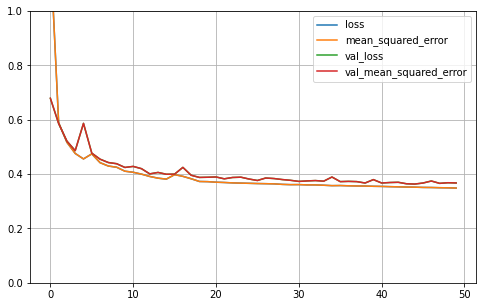

In [10]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

In [11]:
model.evaluate(xtest_scaled, ytest, verbose=0)

[0.36782029271125793, 0.36782029271125793]

In [ ]:
from scipy.stats import reciprocal  # 定义搜索空间
# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers": [1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2)
}

# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
random_search_cv = RandomizedSearchCV(sklearn_model, param_distribution,
                                      n_iter=10, n_jobs=1)
random_search_cv.fit(xtrain_scaled, ytrain, epochs=100,
                     validation_data=(xvalid_scaled, yvalid),
                     callbacks=callbacks)

# 会使用 cross_validation

In [ ]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

In [ ]:
model = random_search_cv.best_estimator_.model
model.evaluate(xtest_scaled, ytest)